In [1]:
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from util.TrainRoutine import AutoEncTrainRoutine
from util.Evaluator import Evaluator
from util.aedpmerf import AEDPMERF

/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We want to use the DPMERF algorithm on time series data. But we will not work on time series directly, because it does not model the temporal relation correctly. Instead we will train an AE first and use DPMERF on the encoding space, where there is no notion of time and ordering.

In [2]:
emb_dim = 32
aedpmerf = AEDPMERF()

------------------------------
Initialising Autoencoder with:
RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 64, batch_first=True)
    (rnn2): LSTM(64, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(32, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)
Training on cuda
------------------------------


In [3]:
model_name = f"lstmae_180_embed{emb_dim}.pth"
if os.path.exists(f"models/{model_name}"):
    aedpmerf.load_ae(model_name)
else:
    model, history = aedpmerf.train_ae()
    plt.plot(history["train"])
    plt.plot(history["val"])
    aedpmerf.save_ae(model_name)

loading AE model from models/lstmae_180_embed32.pth


In [4]:
enc_df = aedpmerf.encode_train_data(train_ds_path="data/normal_train_180.csv", fname=f"data/normal_training_encoded_embed{emb_dim}.csv")
aedpmerf.train_gen(data=enc_df, mini_batch_size=0.1, lr=1e-3)
n_gen_samples = enc_df.shape[0]
gen_data = aedpmerf.generate(n_gen_samples, fname=f"enc_gen_embed{emb_dim}.csv")
pd.DataFrame(gen_data).to_csv(f"data/generated/normal_train_180_embed{emb_dim}_merf.csv")

saving encoded training data in data/normal_training_encoded_embed32.csv
minibatch:  6983
total number of datapoints in the training data is 69818
random freq (1000, 32)
Starting Training
epoch # and running loss are  [0, 6.601976454257965]
epoch # and running loss are  [100, 0.0022920128103578463]
epoch # and running loss are  [200, 0.0016889438702492043]
epoch # and running loss are  [300, 0.001110581957618706]
epoch # and running loss are  [400, 0.001292143904720433]
epoch # and running loss are  [500, 0.0009574975410941988]
epoch # and running loss are  [600, 0.001172201446024701]
epoch # and running loss are  [700, 0.0011045181890949607]
epoch # and running loss are  [800, 0.0008958038088167086]
epoch # and running loss are  [900, 0.0007941233780002221]
epoch # and running loss are  [1000, 0.0010552306994213723]
epoch # and running loss are  [1100, 0.0009681091469246894]
epoch # and running loss are  [1200, 0.0009971368053811602]
epoch # and running loss are  [1300, 0.001183118591

In [16]:
gen_data = pd.read_csv(f"data/generated/normal_train_180_embed{emb_dim}_merf.csv", index_col=0).values.tolist()

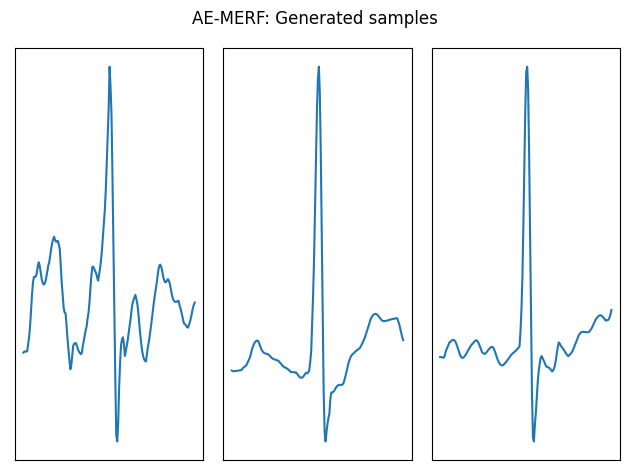

In [25]:
plt.figure()
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(gen_data[i+534])
    plt.xticks([])
    plt.yticks([])
plt.suptitle("AE-MERF: Generated samples")
plt.tight_layout()
plt.show()

In [7]:
ae_gen = AutoEncTrainRoutine()

------------------------------
Initialising Autoencoder with:
RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 64, batch_first=True)
    (rnn2): LSTM(64, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(32, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)
Training on cuda
------------------------------


loss: 83.281479  [    1/69828]
loss: 5.246487  [10001/69828]
loss: 2.537467  [20001/69828]
loss: 3.092171  [30001/69828]
loss: 9.601490  [40001/69828]
loss: 1.967545  [50001/69828]
loss: 1.844594  [60001/69828]
Epoch 1: train loss = 4.860956956135805, val loss = 4.326384218206336
loss: 4.918500  [    1/69828]
loss: 7.628615  [10001/69828]
loss: 1.307343  [20001/69828]
loss: 1.434096  [30001/69828]
loss: 3.066673  [40001/69828]
loss: 7.971358  [50001/69828]
loss: 1.606274  [60001/69828]
Epoch 2: train loss = 2.9138127400597913, val loss = 3.4679039982503443
loss: 3.618920  [    1/69828]
loss: 2.638019  [10001/69828]
loss: 3.357051  [20001/69828]
loss: 3.563899  [30001/69828]
loss: 1.299768  [40001/69828]
loss: 1.816383  [50001/69828]
loss: 1.831063  [60001/69828]
Epoch 3: train loss = 2.2943916281223973, val loss = 3.0293515253561902
loss: 2.108797  [    1/69828]
loss: 0.987052  [10001/69828]
loss: 4.664349  [20001/69828]
loss: 2.100240  [30001/69828]
loss: 0.990691  [40001/69828]
loss:

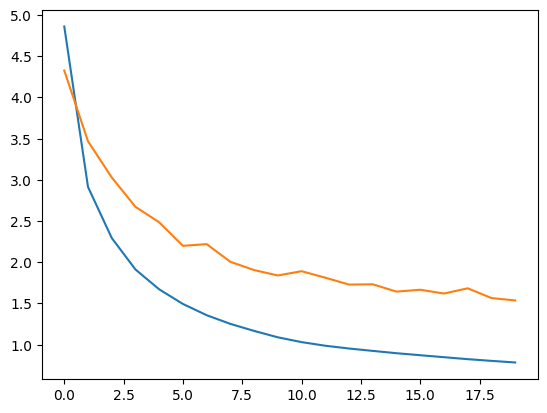

In [8]:
model_name = f"dpmerf_embed{emb_dim}.pth"
if os.path.exists(f"models/{model_name}"):
    ae_gen.load_model(model_name)
else:
    model, history = ae_gen.train_model(train_ds_path=f"data/generated/normal_train_180_embed{emb_dim}_merf.csv", val_ds_path="data/normal_val_180.csv")
    plt.plot(history["train"])
    plt.plot(history["val"])
    ae_gen.save_model(model_name)

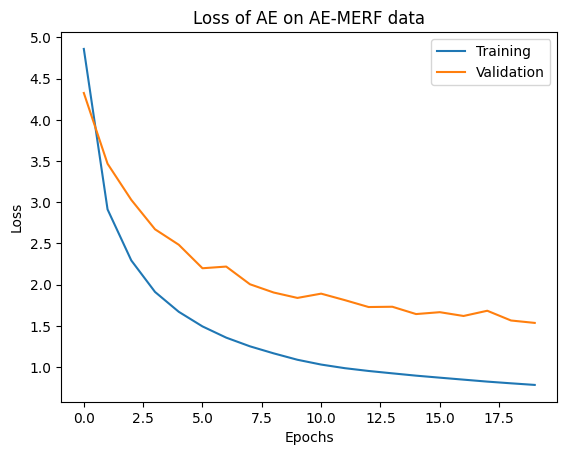

In [10]:
plt.plot(history["train"])
plt.plot(history["val"])
plt.title("Loss of AE on AE-MERF data")
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [11]:
window_size=180
evaluator = Evaluator(val_normal_path=f"data/normal_val_{window_size}.csv",
                      val_anomaly_path=f"data/anomaly_val_{window_size}.csv",
                        test_normal_path=f"data/normal_test{window_size}.csv",
                        test_anomaly_path=f"data/anomalie_test{window_size}.csv", 
                        model=ae_gen.model)

/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([180, 1])) that is different to the input size (torch.Size([1, 180, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


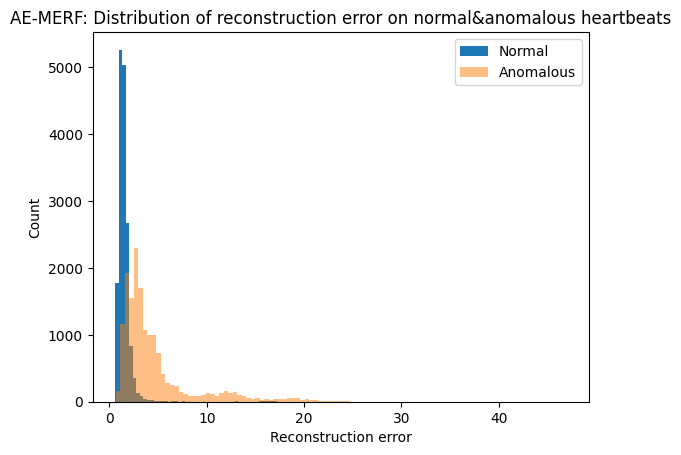

In [19]:
plt.figure()

plt.hist(evaluator.loss_val_normal, bins=100)

plt.title("AE-MERF: Distribution of reconstruction error on normal&anomalous heartbeats")

plt.hist(evaluator.loss_val_anomaly, bins=100, alpha=0.5)
plt.xlabel("Reconstruction error")
plt.ylabel("Count")

plt.legend(["Normal", "Anomalous"])

plt.show()

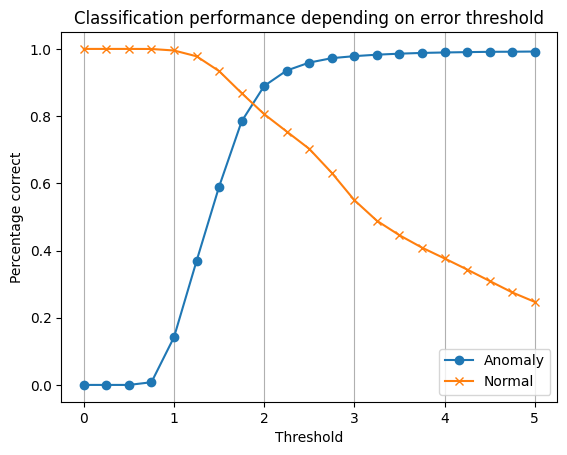

In [22]:
corr_normal, corr_anomaly = evaluator.find_threshold()
plt.plot(np.linspace(0,5,21), corr_normal, marker="o")
plt.plot(np.linspace(0,5,21), corr_anomaly, marker="x")
plt.xlabel("Threshold")
plt.ylabel("Percentage correct")
plt.legend(["Anomaly", "Normal"])
plt.title("Classification performance depending on error threshold")
plt.grid(axis="x")
plt.show()

In [23]:
predictions_normal, predictions_anomaly = evaluator.predict_class(1.75)


/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([180, 1])) that is different to the input size (torch.Size([1, 180, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


In [24]:
evaluator.evaluate(predictions_normal, predictions_anomaly)

TP: 1392
FN: 368
FP: 242
TN: 1562
Acc: 0.8288439955106621
Precision: 0.8518971848225214
Recall: 0.7909090909090909
F1: 0.8202710665880966
